# Style transfer

This notebook illustrates how you would apply style transfer.

In [1]:
!pip install keras --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import Model, ops
from keras.layers import Input
from keras.applications import vgg19
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing import image

from dl_utils import download_image, KerasOptimizer

We'll use these images:

In [27]:
base_image_path = "/content/img.jpg"
style_image_path = "/content/gog.jpg"

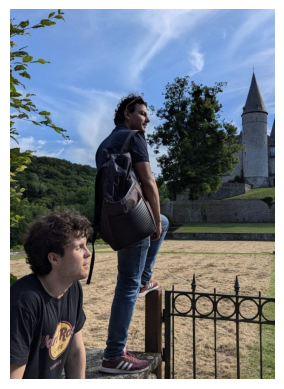

In [24]:
from PIL import Image

# Load the image
image = Image.open(base_image_path)
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


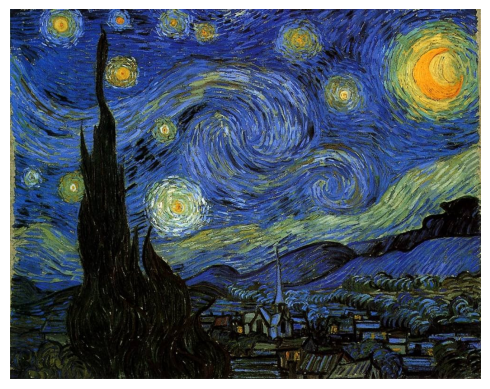

In [28]:
# Load the image
image = Image.open(style_image_path)
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


We define helper functions to preprocess and deprocess images (based on what VGG19 expects).

In [29]:
def preprocess_image(path, size):
    image_original = download_image(path, convert_to_array=False)
    image_original = image_original.resize(size)
    image_processed = image_original.copy()
   # image_processed = image.img_to_array(image_processed)
    image_processed = np.expand_dims(image_processed, axis=0)
    image_processed = vgg19.preprocess_input(image_processed)
    return image_original, image_processed[0]

def deprocess_image(x):
    x = x.numpy().reshape((x.shape[1], x.shape[2], 3))
    # VGG19 preprocess by normalizing each channel with the ImageNet means, so we just add these back up
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # We also need to convert back from (blue, green, red) to (red, green, blue)
    x = x[:, :, ::-1]
    # Finally, we clip all values between 0 and 255
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [30]:

def preprocess_image_local(image_path, target_size):
    """
    Load an image from a local path and resize it to the target size.

    Args:
    - image_path (str): The path to the image.
    - target_size (tuple): The target size as (width, height).

    Returns:
    - base_img_original (PIL.Image.Image): The original image.
    - base_img_processed (PIL.Image.Image): The resized image.
    """
    # Load the original image
    base_img_original = Image.open(image_path)

    # Resize the image to the target size
    base_img_processed = base_img_original.resize(target_size, Image.ANTIALIAS)
    base_img_processed = np.expand_dims(base_img_processed, axis=0)
    base_img_processed = vgg19.preprocess_input(base_img_processed)

    return base_img_original,base_img_processed



These are the starting images we will work with:

In [31]:
img_ncols, img_nrows = 400, 300

In [32]:
base_img_original, base_img_processed = preprocess_image_local(base_image_path, (img_ncols, img_nrows))
style_img_original, style_img_processed = preprocess_image_local(style_image_path, (img_ncols, img_nrows))

<ipython-input-30-d2e920cbd27b>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  base_img_processed = base_img_original.resize(target_size, Image.ANTIALIAS)


In [33]:
base_img_processed[0].shape

(300, 400, 3)

Next, we define our model, loss components, and a function summing all losses together.

In [34]:
input_shape = base_img_processed[0].shape
model = vgg19.VGG19(input_tensor=Input(input_shape), weights="imagenet", include_top=False)

def content_loss(base, combination):
    return ops.sum(ops.square(combination - base))

def gram_matrix(x):
    x = ops.transpose(x, (2, 0, 1))
    features = ops.reshape(x, (ops.shape(x)[0], -1))
    gram = ops.matmul(features, ops.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return ops.sum(ops.square(S - C)) / (4.0 * (channels**2) * (size**2))

def total_variation_loss(x, p=1.25):
    a = ops.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = ops.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return ops.sum(ops.power(a + b, p))

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

total_variation_weight = ops.cast(1e-6, "float32")
style_weight = ops.cast(2e-6, "float32")
content_weight = ops.cast(2e-8, "float32")

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = ops.concatenate([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = 0
    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    return loss

In [35]:
optimizer = KerasOptimizer([compute_loss])

In [36]:
learning_rate=200.0
combination_image = np.expand_dims(base_img_processed[0], axis=0)

0: loss = <tf.Tensor: shape=(), dtype=float32, numpy=53994.926> learning_rate = 200.0


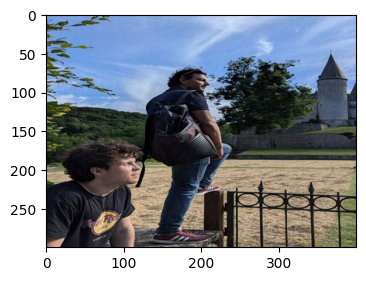

100: loss = <tf.Tensor: shape=(), dtype=float32, numpy=2704.389> learning_rate = 200.0


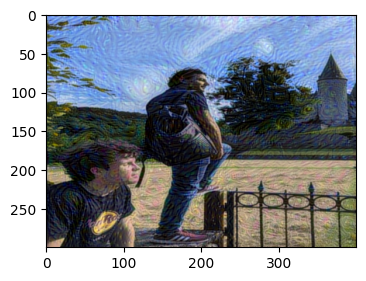

200: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1969.1384> learning_rate = 200.0


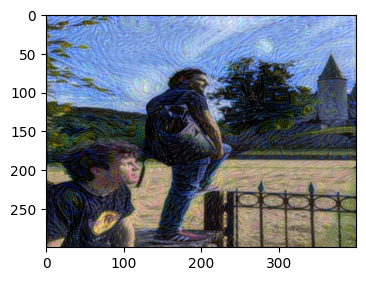

300: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1653.8175> learning_rate = 200.0


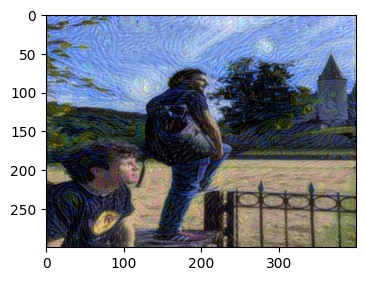

400: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1511.9427> learning_rate = 200.0


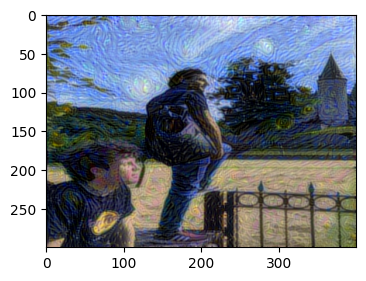

500: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1433.3743> learning_rate = 200.0


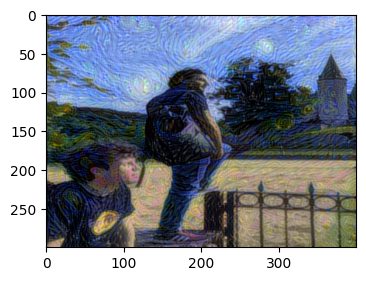

600: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1358.4982> learning_rate = 200.0


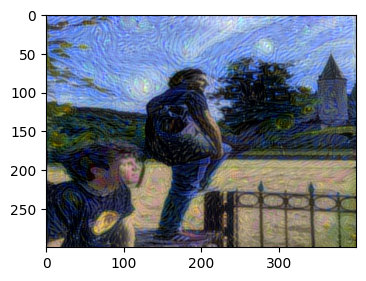

700: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1307.4745> learning_rate = 200.0


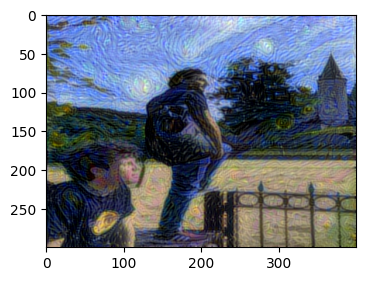

800: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1271.9482> learning_rate = 200.0


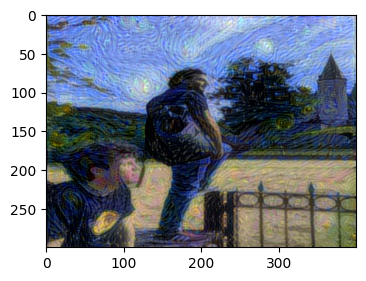

900: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1234.7654> learning_rate = 200.0


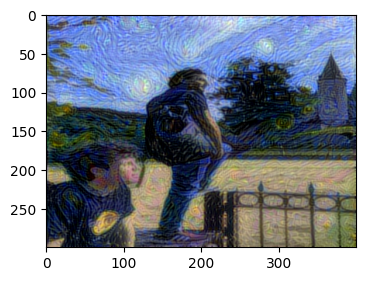

1000: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1234.1285> learning_rate = 200.0


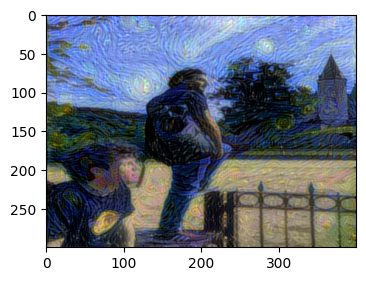

1100: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1237.6676> learning_rate = 200.0


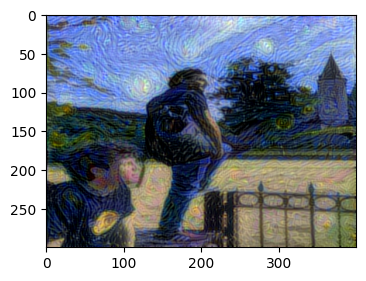

1200: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1204.3878> learning_rate = 200.0


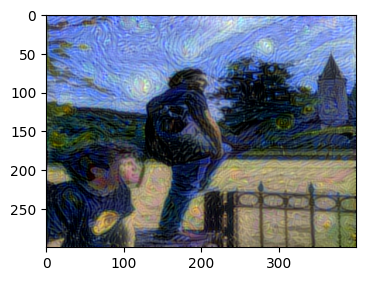

1300: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1224.3743> learning_rate = 200.0


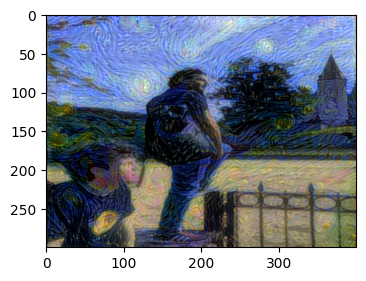

1400: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1224.5836> learning_rate = 200.0


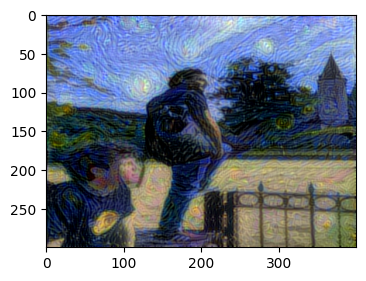

1500: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1184.7777> learning_rate = 200.0


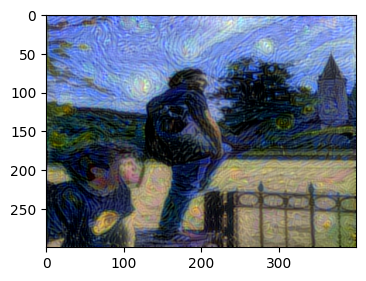

1600: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1151.288> learning_rate = 200.0


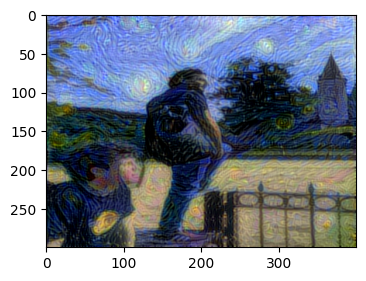

1700: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1156.3947> learning_rate = 200.0


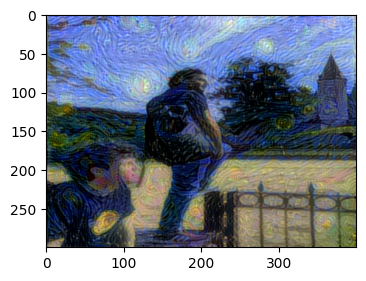

1800: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1131.5406> learning_rate = 200.0


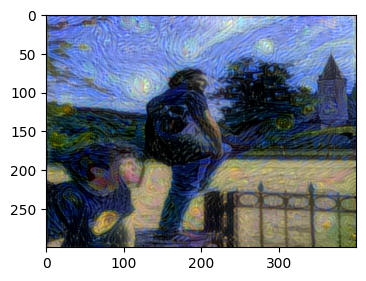

1900: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1107.544> learning_rate = 200.0


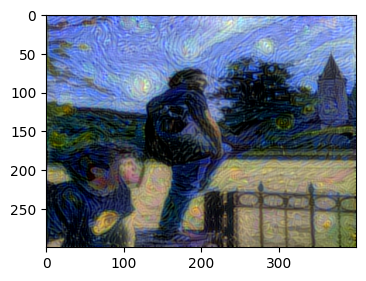

2000: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1104.7859> learning_rate = 200.0


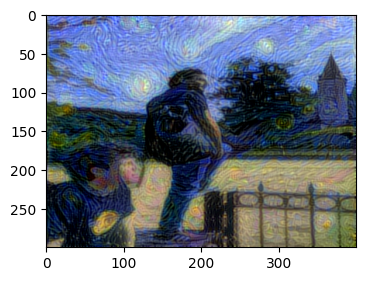

In [ ]:
for _ in range(3000):
    combination_image, loss = optimizer.optimize(
        x=combination_image,
        iterations=2,
        learning_rate=learning_rate,
        base_image=np.expand_dims(base_img_processed[0], axis=0),
        style_reference_image=np.expand_dims(style_img_processed[0], axis=0)
    )
    if _ % 100 == 0:
        print(f"{_}: {loss = } {learning_rate = }")
        combined_image_deprocessed = deprocess_image(combination_image)
        plt.figure(figsize=(4, 5))
        plt.imshow(combined_image_deprocessed)
        plt.show()